In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm
from utils import sliding_correlation

In [2]:
load_dotenv()
dataset_path = os.getenv("DATASET_PATH")

In [3]:
with open(os.path.join(dataset_path, "dataset_metadata.json"), "r") as f:
    dataset_metadata = json.load(f)

In [4]:
for artist, songs in list(dataset_metadata.items()):
    for song in list(songs.keys()):
        if (
            dataset_metadata[artist][song]["layout"] is None
            or None in dataset_metadata[artist][song]["layout"]
        ):
            print(f"Removing {artist} - {song}: invalid layout")
            del dataset_metadata[artist][song]
            continue
        if dataset_metadata[artist][song]["moving_camera"]:
            print(f"Removing {artist} - {song}: moving camera")
            del dataset_metadata[artist][song]
            continue
        if dataset_metadata[artist][song]["layout"] != [
            "violin",
            "vocal",
            "mridangam",
        ]:
            print(f"Removing {artist} - {song}: instrument mismatch")
            del dataset_metadata[artist][song]

    if len(dataset_metadata[artist]) == 0:
        del dataset_metadata[artist]

Removing Abhiram Bode - Devi Pavane: instrument mismatch
Removing Abhiram Bode - Entha Bhagyamu: instrument mismatch
Removing Abhiram Bode - Kalaye: instrument mismatch
Removing Abhiram Bode - Lekanna ninnu: instrument mismatch
Removing Abhiram Bode - Nadatina: instrument mismatch
Removing Abhishek Ravi Shankar - Brindavanam Idhuvo: instrument mismatch
Removing Abhishek Ravi Shankar - Kamakshi Varlakshmi: instrument mismatch
Removing Abhishek Ravi Shankar - Manasa Etulo: moving camera
Removing Abhishek Ravi Shankar - Palaya Sada: instrument mismatch
Removing Abhishek Ravi Shankar - Sami Ninne: instrument mismatch
Removing Abhishek Ravi Shankar - Tappagane Vachunna: invalid layout
Removing Aditi Prahalad - Ananda Natana Prakasham: instrument mismatch
Removing Aditi Prahalad - Jalajasha Ninne: instrument mismatch
Removing Aditi Prahalad - Kangali: instrument mismatch
Removing Aditi Prahalad - Nannu Brova: instrument mismatch
Removing Aditi Prahalad - Parama Pavana Rama: instrument mismat

In [5]:
print(f"number of artists after filtering: {len(dataset_metadata)}")
print(
    f"number of songs after filtering: {sum(len(songs) for songs in dataset_metadata.values())}"
)

number of artists after filtering: 3
number of songs after filtering: 16


In [6]:
violin_motion_features = {}
motion_features = {}
audio_features = {}

for artist, songs in tqdm(dataset_metadata.items(), desc="Artists"):
    artist_dir = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_dir) or artist.startswith("."):
        continue

    violin_motion_features.setdefault(artist, {})
    motion_features.setdefault(artist, {})
    audio_features.setdefault(artist, {})

    for song in tqdm(songs, desc="Songs", leave=False):
        song_dir = os.path.join(artist_dir, song)
        if not os.path.isdir(song_dir) or song.startswith("."):
            continue

        violin_motion_features[artist].setdefault(song, {})
        motion_features[artist].setdefault(song, {})
        audio_features[artist].setdefault(song, {})

        instrument_dir = os.path.join(song_dir, "violin")
        if not os.path.exists(instrument_dir):
            continue

        try:
            print(f"Processing {artist}/{song}...")
            with open(
                os.path.join(instrument_dir, "motion_features.json"), "r"
            ) as f:
                motion_features[artist][song] = json.load(f)
            with open(
                os.path.join(instrument_dir, "violin_motion_features.json"),
                "r",
            ) as f:
                violin_motion_features[artist][song] = json.load(f)
            with open(
                os.path.join(instrument_dir, "audio_features.json"), "r"
            ) as f:
                audio_features[artist][song] = json.load(f)
        except FileNotFoundError:
            print(f"File not found for {artist}/{song}.")
            continue

Artists:   0%|          | 0/3 [00:00<?, ?it/s]

Processing Archana Murali/Ee Vasudha...


Songs:  20%|██        | 1/5 [00:00<00:01,  2.64it/s]

Processing Archana Murali/Enthani Vina...
Processing Archana Murali/Janani Ninnuvina...


Songs:  60%|██████    | 3/5 [00:01<00:00,  3.02it/s]

Processing Archana Murali/Sanchalam Theertharul...
Processing Archana Murali/Thillana...


Artists:  33%|███▎      | 1/3 [00:01<00:02,  1.29s/it]

Processing Bhargavi Chandrasekar/Anjaneya Raghurama...


Songs:  12%|█▎        | 1/8 [00:00<00:03,  2.27it/s]

Processing Bhargavi Chandrasekar/Challare Rmachandru...
Processing Bhargavi Chandrasekar/Muladhara Kshetra...


Songs:  38%|███▊      | 3/8 [00:00<00:00,  5.27it/s]

Processing Bhargavi Chandrasekar/Navaragamalika Varnam...
Processing Bhargavi Chandrasekar/Sri Kantimatim...


Songs:  62%|██████▎   | 5/8 [00:01<00:00,  4.47it/s]

Processing Bhargavi Chandrasekar/Thillai Ambalathanai...
Processing Bhargavi Chandrasekar/Thillana...
Processing Bhargavi Chandrasekar/Vara Narada...


Artists:  67%|██████▋   | 2/3 [00:02<00:01,  1.37s/it]

Processing Srividya Vadnamali/Parama Prusham...
Processing Srividya Vadnamali/Raju Vedale...


Artists: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]A

Processing Srividya Vadnamali/Thillana...


## Case study

In [7]:
artist = "Bhargavi Chandrasekar"
song = "Challare Rmachandru"

In [8]:
# Motion features we want to analyze
motion_features_to_analyze = ["wrist_speed", "elbow_angle", "arm_extension"]

# Initialize results dictionary
violin_strong_windows = {artist: {song: {}}}

fps = 30
window_size = int(0.5 * fps)  # 0.5 second windows
step_size = int(0.1 * fps)  # 0.1 second steps

print(f"Analyzing {artist} - {song}")
print(f"Window size: {window_size} frames ({window_size/fps:.1f}s)")
print(f"Step size: {step_size} frames ({step_size/fps:.1f}s)")

# Get the audio features
audio_onset_env = audio_features[artist][song]["onset_env"]
audio_rms = audio_features[artist][song]["rms"]

for motion_feature in motion_features_to_analyze:
    if motion_feature not in violin_strong_windows[artist][song]:
        violin_strong_windows[artist][song][motion_feature] = {}

    print(f"\nAnalyzing {motion_feature}...")

    # Get the motion feature data
    motion_data = violin_motion_features[artist][song][motion_feature]

    # Compute sliding correlation with onset_env
    correlations_onset, times_onset, strong_correlation_windows_onset = (
        sliding_correlation(
            motion_data,
            audio_onset_env,
            window_size,
            step_size,
            fps,
            threshold=0.5,  # Strong correlation threshold
        )
    )

    # Compute sliding correlation with rms
    correlations_rms, times_rms, strong_correlation_windows_rms = (
        sliding_correlation(
            motion_data,
            audio_rms,
            window_size,
            step_size,
            fps,
            threshold=0.5,  # Strong correlation threshold
        )
    )

    # Store results
    violin_strong_windows[artist][song][motion_feature] = {
        "correlations_onset": correlations_onset.tolist(),
        "times_onset": times_onset.tolist(),
        "strong_windows_onset": strong_correlation_windows_onset,
        "num_strong_windows_onset": len(strong_correlation_windows_onset),
        "correlations_rms": correlations_rms.tolist(),
        "times_rms": times_rms.tolist(),
        "strong_windows_rms": strong_correlation_windows_rms,
        "num_strong_windows_rms": len(strong_correlation_windows_rms),
    }

    print(
        f"Found {len(strong_correlation_windows_onset)} strong correlation windows for {motion_feature} (onset_env)"
    )
    if strong_correlation_windows_onset:
        print("Strong correlation periods (onset_env):")
        for time, corr in strong_correlation_windows_onset:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

    print(
        f"Found {len(strong_correlation_windows_rms)} strong correlation windows for {motion_feature} (rms)"
    )
    if strong_correlation_windows_rms:
        print("Strong correlation periods (rms):")
        for time, corr in strong_correlation_windows_rms:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

Analyzing Bhargavi Chandrasekar - Challare Rmachandru
Window size: 15 frames (0.5s)
Step size: 3 frames (0.1s)

Analyzing wrist_speed...
Found 108 strong correlation windows for wrist_speed (onset_env)Found 108 strong correlation windows for wrist_speed (onset_env)
Strong correlation periods (onset_env):
  Time: 0.60s, Correlation: -0.570
  Time: 1.90s, Correlation: 0.563
  Time: 11.10s, Correlation: -0.523
  Time: 11.20s, Correlation: -0.694
  Time: 12.70s, Correlation: 0.653
  Time: 12.80s, Correlation: 0.720
  Time: 12.90s, Correlation: 0.793
  Time: 13.00s, Correlation: 0.744
  Time: 13.10s, Correlation: 0.559
  Time: 19.40s, Correlation: 0.663
  Time: 24.80s, Correlation: 0.649
  Time: 24.90s, Correlation: 0.677
  Time: 25.00s, Correlation: 0.586
  Time: 25.10s, Correlation: 0.571
  Time: 25.20s, Correlation: 0.524
  Time: 25.80s, Correlation: -0.564
  Time: 29.90s, Correlation: 0.517
  Time: 33.20s, Correlation: 0.554
  Time: 33.30s, Correlation: 0.555
  Time: 36.20s, Correlation


CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS

WRIST_SPEED COMPARISON (Full Signal Stats):
  ONSET ENVELOPE:
    Mean correlation: 0.004
    Max correlation: 0.869
    Strong correlation windows: 108
    % of time with strong correlation: 6.7%
  RMS ENERGY:
    Mean correlation: 0.065
    Max correlation: 0.918
    Strong correlation windows: 253
    % of time with strong correlation: 15.7%
  → RMS energy shows better correlation (15.7% vs 6.7%)

ELBOW_ANGLE COMPARISON (Full Signal Stats):
  ONSET ENVELOPE:
    Mean correlation: -0.004
    Max correlation: 0.924
    Strong correlation windows: 82
    % of time with strong correlation: 5.1%
  RMS ENERGY:
    Mean correlation: -0.113
    Max correlation: 0.977
    Strong correlation windows: 732
    % of time with strong correlation: 45.4%
  → RMS energy shows better correlation (45.4% vs 5.1%)

ARM_EXTENSION COMPARISON (Full Signal Stats):
  ONSET ENVELOPE:
    Mean correlation: 0.026
    Max correlation: 0.942
    Strong correlation

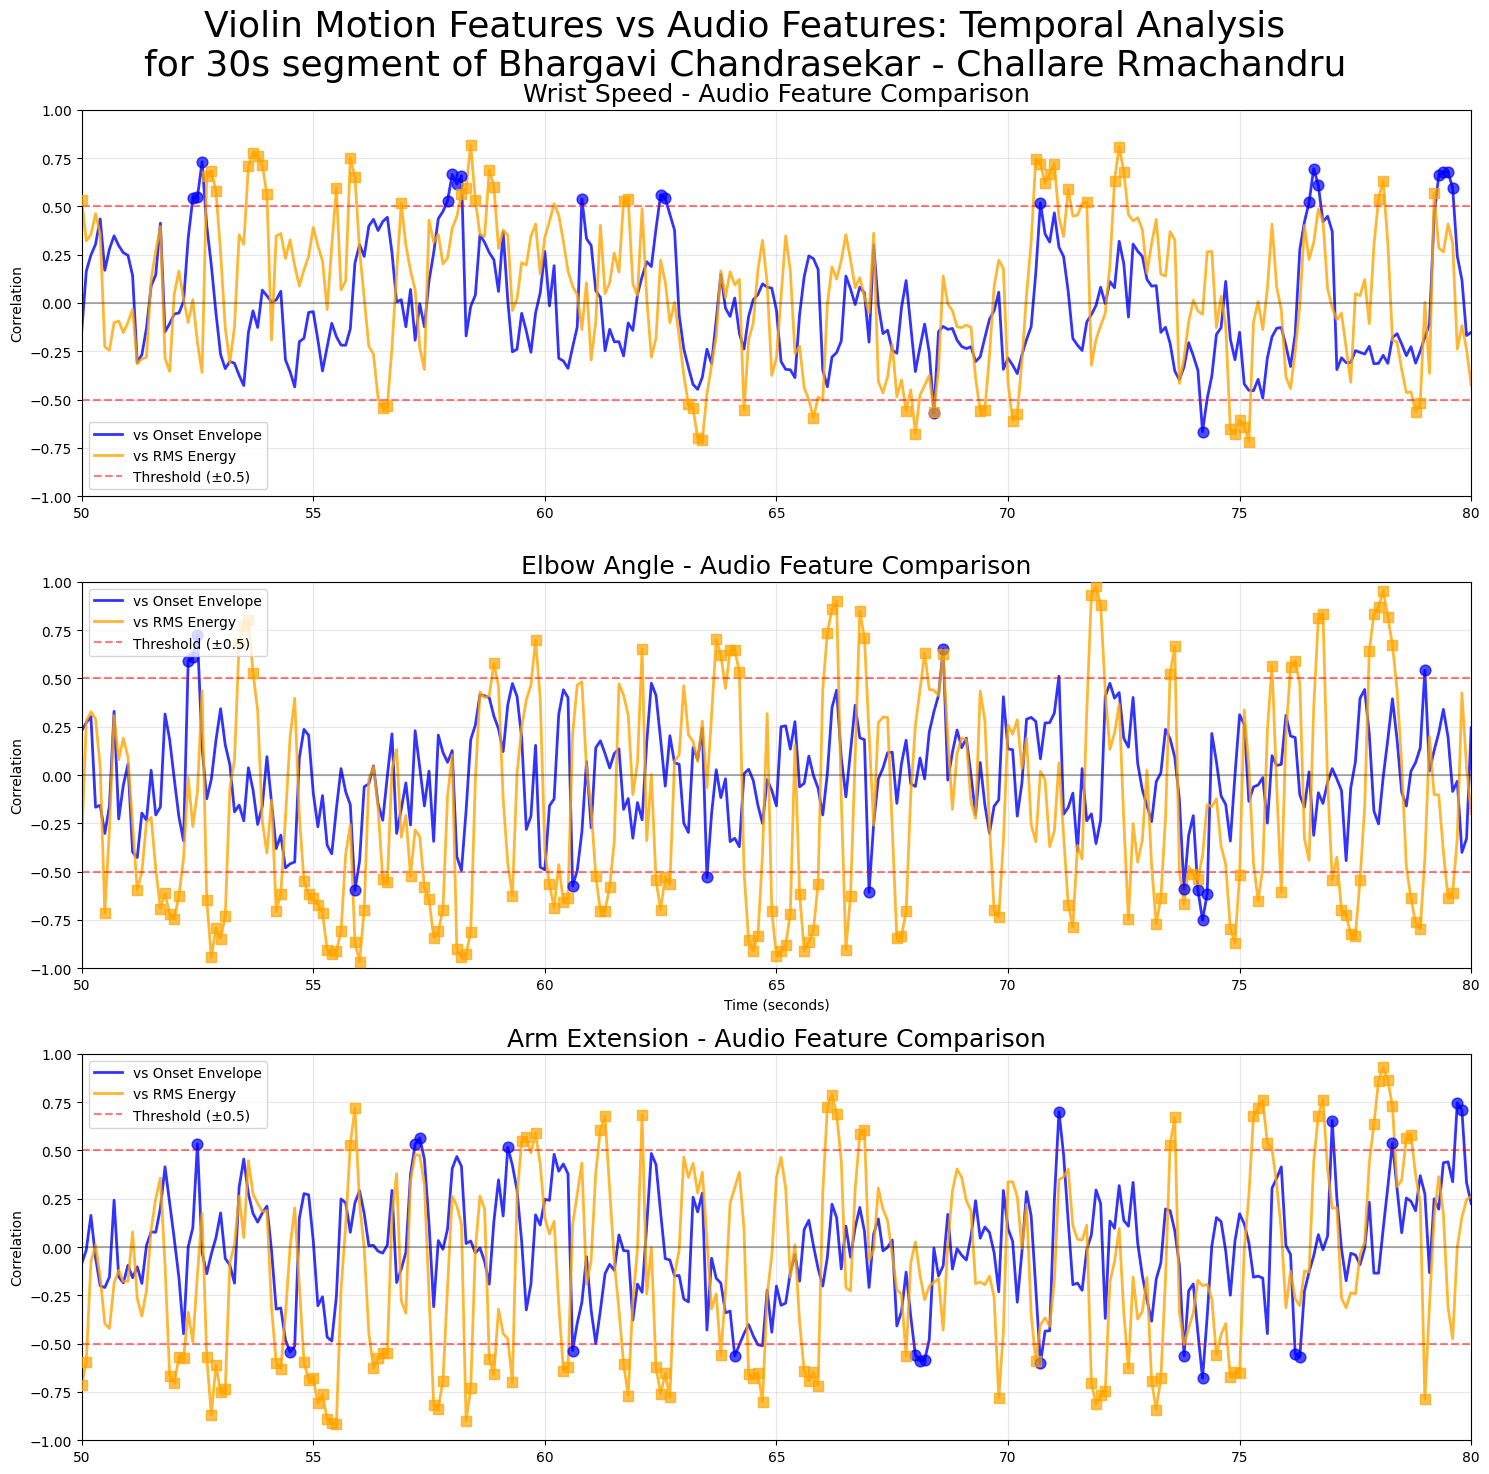


OVERALL AUDIO FEATURE COMPARISON SUMMARY
Total strong correlation windows:
  Onset Envelope: 313
  RMS Energy: 1532

✓ RMS Energy overall shows better correlation with violin motion features!


In [10]:
# Summary and visualization of results with onset env and RMS overlay

print("\n" + "=" * 60)
print("CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS")
print("=" * 60)

# Time interval (seconds) to display for illustration
start_time = 50
end_time = 80

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle(
    f"Violin Motion Features vs Audio Features: Temporal Analysis\nfor 30s segment of {artist} - {song}",
    fontsize=26,
)

for i, motion_feature in enumerate(motion_features_to_analyze):
    results = violin_strong_windows[artist][song][motion_feature]

    ax = axes[i]

    # Convert to numpy arrays for masking
    times_onset_arr = np.array(results["times_onset"])  # seconds
    corr_onset_arr = np.array(results["correlations_onset"])
    times_rms_arr = np.array(results["times_rms"])  # seconds
    corr_rms_arr = np.array(results["correlations_rms"])

    # Masks for the selected time window
    mask_onset = (times_onset_arr >= start_time) & (
        times_onset_arr <= end_time
    )
    mask_rms = (times_rms_arr >= start_time) & (times_rms_arr <= end_time)

    # Plot both onset and RMS correlations (restricted interval)
    ax.plot(
        times_onset_arr[mask_onset],
        corr_onset_arr[mask_onset],
        alpha=0.8,
        linewidth=2,
        color="blue",
        label="vs Onset Envelope",
    )
    ax.plot(
        times_rms_arr[mask_rms],
        corr_rms_arr[mask_rms],
        alpha=0.8,
        linewidth=2,
        color="orange",
        label="vs RMS Energy",
    )

    # Threshold lines
    ax.axhline(
        y=0.5, color="r", linestyle="--", alpha=0.5, label="Threshold (±0.5)"
    )
    ax.axhline(y=-0.5, color="r", linestyle="--", alpha=0.5)
    ax.axhline(y=0, color="k", linestyle="-", alpha=0.3)

    # Mark strong correlation windows (only those in selected interval)
    for time, corr in results["strong_windows_onset"]:
        if start_time <= time <= end_time:
            ax.scatter(
                time, corr, color="blue", s=60, zorder=5, marker="o", alpha=0.7
            )

    for time, corr in results["strong_windows_rms"]:
        if start_time <= time <= end_time:
            ax.scatter(
                time,
                corr,
                color="orange",
                s=60,
                zorder=5,
                marker="s",
                alpha=0.7,
            )

    ax.set_title(
        f'{motion_feature.replace("_", " ").title()} - Audio Feature Comparison',
        fontsize=18,
    )
    if i == 1:
        ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Correlation")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim(-1, 1)
    ax.set_xlim(start_time, end_time)

    # Print summary statistics for both audio features (full-series stats retained)
    correlations_onset = corr_onset_arr
    correlations_rms = corr_rms_arr

    print(f"\n{motion_feature.upper()} COMPARISON (Full Signal Stats):")
    print("  ONSET ENVELOPE:")
    print(f"    Mean correlation: {np.nanmean(correlations_onset):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_onset):.3f}")
    print(
        f"    Strong correlation windows: {results['num_strong_windows_onset']}"
    )
    print(
        f"    % of time with strong correlation: {results['num_strong_windows_onset'] / len(correlations_onset) * 100:.1f}%"
    )

    print("  RMS ENERGY:")
    print(f"    Mean correlation: {np.nanmean(correlations_rms):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_rms):.3f}")
    print(
        f"    Strong correlation windows: {results['num_strong_windows_rms']}"
    )
    print(
        f"    % of time with strong correlation: {results['num_strong_windows_rms'] / len(correlations_rms) * 100:.1f}%"
    )

    # Determine which audio feature correlates better (global)
    onset_pct = (
        results["num_strong_windows_onset"] / len(correlations_onset) * 100
    )
    rms_pct = results["num_strong_windows_rms"] / len(correlations_rms) * 100

    if rms_pct > onset_pct:
        print(
            f"  → RMS energy shows better correlation ({rms_pct:.1f}% vs {onset_pct:.1f}%)"
        )
    else:
        print(
            f"  → Onset envelope shows better correlation ({onset_pct:.1f}% vs {rms_pct:.1f}%)"
        )

plt.tight_layout()
plt.show()

# Overall comparison summary (unchanged, uses full data)
print(f"\n{'='*60}")
print("OVERALL AUDIO FEATURE COMPARISON SUMMARY")
print(f"{'='*60}")

total_onset_windows = sum(
    violin_strong_windows[artist][song][feat]["num_strong_windows_onset"]
    for feat in motion_features_to_analyze
)
total_rms_windows = sum(
    violin_strong_windows[artist][song][feat]["num_strong_windows_rms"]
    for feat in motion_features_to_analyze
)

print("Total strong correlation windows:")
print(f"  Onset Envelope: {total_onset_windows}")
print(f"  RMS Energy: {total_rms_windows}")

if total_rms_windows > total_onset_windows:
    print(
        "\n✓ RMS Energy overall shows better correlation with violin motion features!"
    )
else:
    print(
        "\n✓ Onset Envelope overall shows better correlation with violin motion features!"
    )


CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS

WRIST_SPEED COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: 0.004
    Max correlation: 0.869
    Strong correlation windows: 108
    % of time with strong correlation: 6.7%
  RMS ENERGY:
    Mean correlation: 0.065
    Max correlation: 0.918
    Strong correlation windows: 253
    % of time with strong correlation: 15.7%
  → RMS energy shows better correlation (15.7% vs 6.7%)

ELBOW_ANGLE COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: -0.004
    Max correlation: 0.924
    Strong correlation windows: 82
    % of time with strong correlation: 5.1%
  RMS ENERGY:
    Mean correlation: -0.113
    Max correlation: 0.977
    Strong correlation windows: 732
    % of time with strong correlation: 45.4%
  → RMS energy shows better correlation (45.4% vs 5.1%)

ARM_EXTENSION COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: 0.026
    Max correlation: 0.942
    Strong correlation windows: 123
    % of time with strong correlation: 7.6%
  

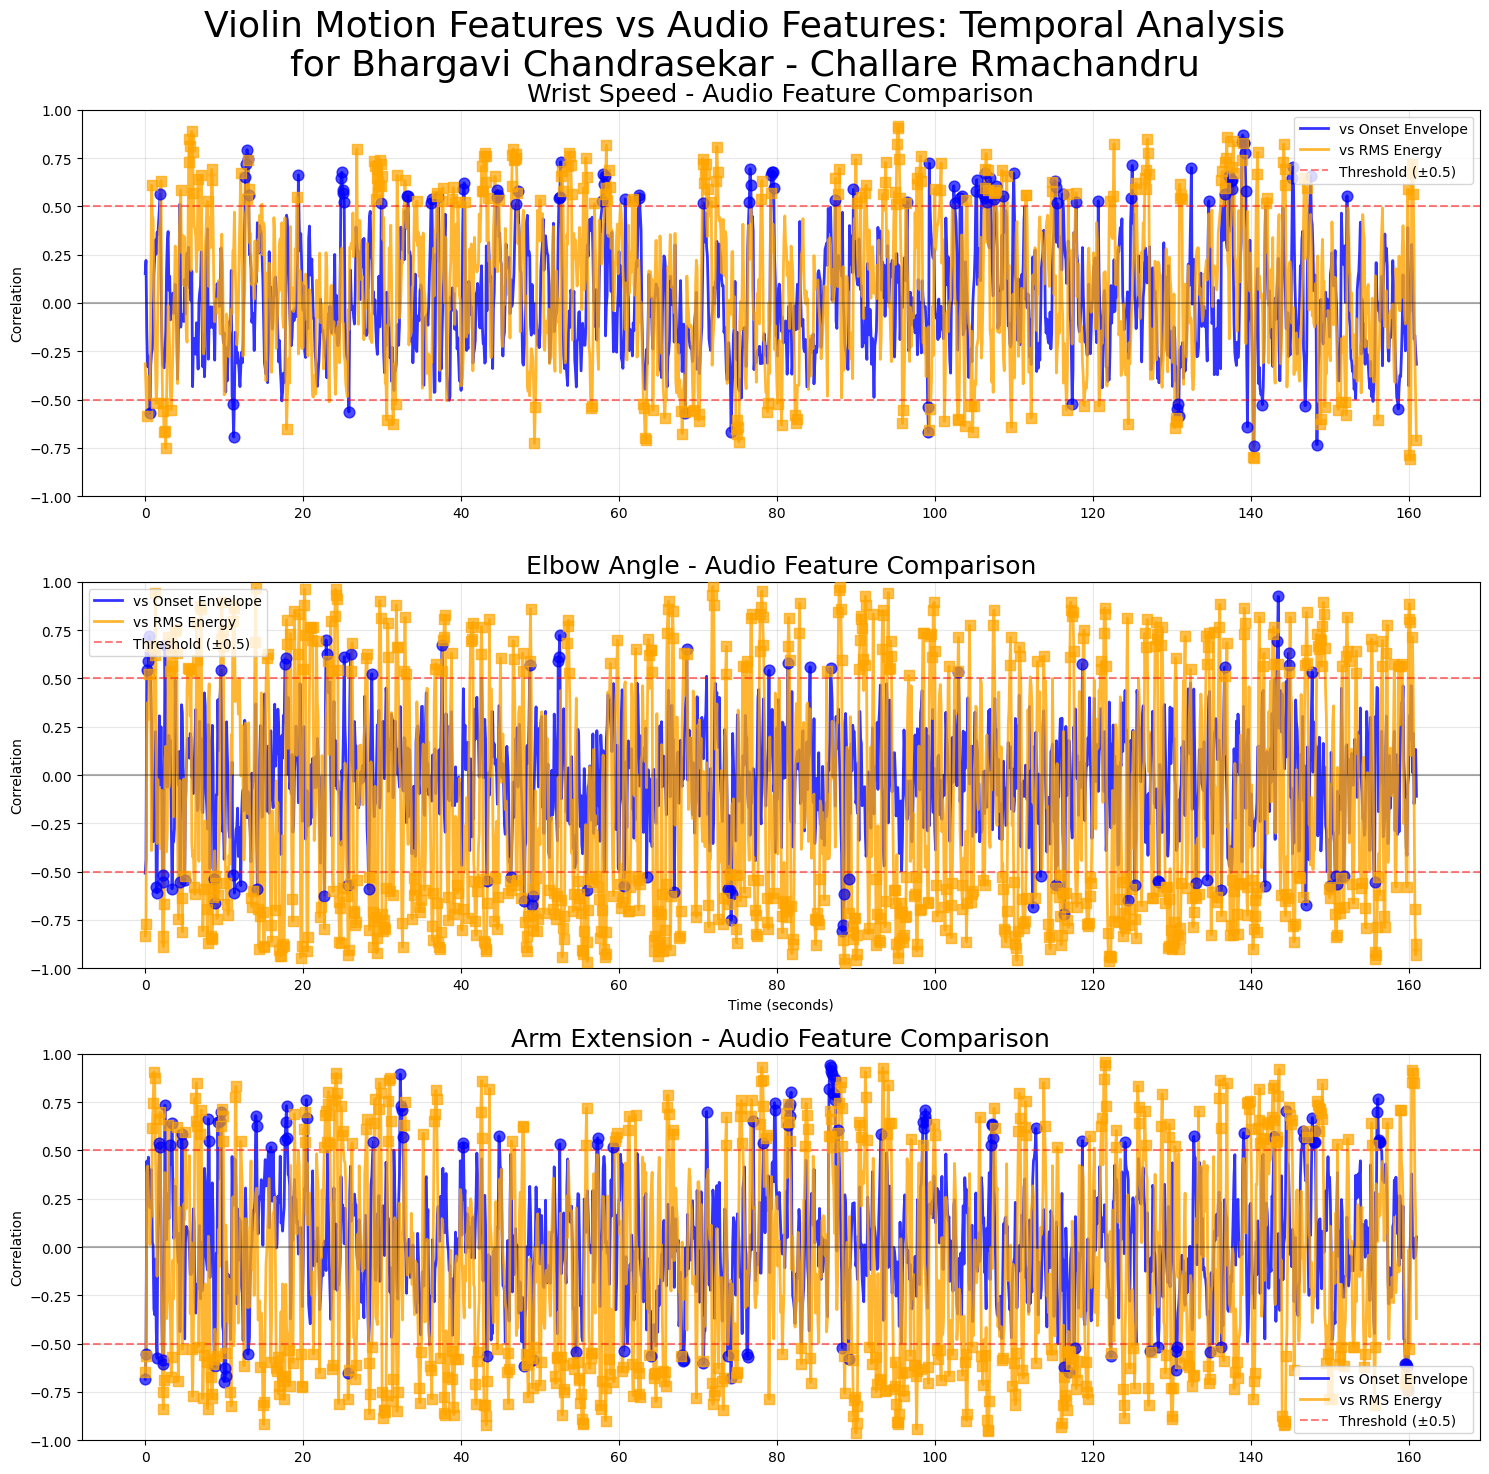


OVERALL AUDIO FEATURE COMPARISON SUMMARY
Total strong correlation windows:
  Onset Envelope: 313
  RMS Energy: 1532

✓ RMS Energy overall shows better correlation with violin motion features!


In [23]:
# Summary and visualization of results with onset env and RMS overlay

print("\n" + "=" * 60)
print("CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS")
print("=" * 60)

fig, axes = plt.subplots(3, 1, figsize=(15, 15))
fig.suptitle(
    f"Violin Motion Features vs Audio Features: Temporal Analysis\nfor {artist} - {song}",
    fontsize=26,
)

for i, motion_feature in enumerate(motion_features_to_analyze):
    results = violin_strong_windows[artist][song][motion_feature]

    ax = axes[i]

    # Plot both onset and RMS correlations
    ax.plot(
        results["times_onset"],
        results["correlations_onset"],
        alpha=0.8,
        linewidth=2,
        color="blue",
        label="vs Onset Envelope",
    )
    ax.plot(
        results["times_rms"],
        results["correlations_rms"],
        alpha=0.8,
        linewidth=2,
        color="orange",
        label="vs RMS Energy",
    )

    # Threshold lines
    ax.axhline(
        y=0.5, color="r", linestyle="--", alpha=0.5, label="Threshold (±0.5)"
    )
    ax.axhline(y=-0.5, color="r", linestyle="--", alpha=0.5)
    ax.axhline(y=0, color="k", linestyle="-", alpha=0.3)

    # Mark strong correlation windows with different markers
    for time, corr in results["strong_windows_onset"]:
        ax.scatter(
            time, corr, color="blue", s=60, zorder=5, marker="o", alpha=0.7
        )

    for time, corr in results["strong_windows_rms"]:
        ax.scatter(
            time, corr, color="orange", s=60, zorder=5, marker="s", alpha=0.7
        )

    ax.set_title(
        f'{motion_feature.replace("_", " ").title()} - Audio Feature Comparison',
        fontsize=18,
    )
    if i == 1:
        ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Correlation")
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim(-1, 1)

    # Print summary statistics for both audio features
    correlations_onset = np.array(results["correlations_onset"])
    correlations_rms = np.array(results["correlations_rms"])

    print(f"\n{motion_feature.upper()} COMPARISON:")
    print("  ONSET ENVELOPE:")
    print(f"    Mean correlation: {np.nanmean(correlations_onset):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_onset):.3f}")
    print(
        f"    Strong correlation windows: {results['num_strong_windows_onset']}"
    )
    print(
        f"    % of time with strong correlation: {results['num_strong_windows_onset'] / len(correlations_onset) * 100:.1f}%"
    )

    print("  RMS ENERGY:")
    print(f"    Mean correlation: {np.nanmean(correlations_rms):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_rms):.3f}")
    print(
        f"    Strong correlation windows: {results['num_strong_windows_rms']}"
    )
    print(
        f"    % of time with strong correlation: {results['num_strong_windows_rms'] / len(correlations_rms) * 100:.1f}%"
    )

    # Determine which audio feature correlates better
    onset_pct = (
        results["num_strong_windows_onset"] / len(correlations_onset) * 100
    )
    rms_pct = results["num_strong_windows_rms"] / len(correlations_rms) * 100

    if rms_pct > onset_pct:
        print(
            f"  → RMS energy shows better correlation ({rms_pct:.1f}% vs {onset_pct:.1f}%)"
        )
    else:
        print(
            f"  → Onset envelope shows better correlation ({onset_pct:.1f}% vs {rms_pct:.1f}%)"
        )

plt.tight_layout()
plt.show()

# Overall comparison summary
print(f"\n{'='*60}")
print("OVERALL AUDIO FEATURE COMPARISON SUMMARY")
print(f"{'='*60}")

total_onset_windows = sum(
    violin_strong_windows[artist][song][feat]["num_strong_windows_onset"]
    for feat in motion_features_to_analyze
)
total_rms_windows = sum(
    violin_strong_windows[artist][song][feat]["num_strong_windows_rms"]
    for feat in motion_features_to_analyze
)

print("Total strong correlation windows:")
print(f"  Onset Envelope: {total_onset_windows}")
print(f"  RMS Energy: {total_rms_windows}")

if total_rms_windows > total_onset_windows:
    print(
        "\n✓ RMS Energy overall shows better correlation with violin motion features!"
    )
else:
    print(
        "\n✓ Onset Envelope overall shows better correlation with violin motion features!"
    )

## Global study

In [10]:
violin_features_list = motion_features_to_analyze
general_features_list = ["mean_speed", "mean_acceleration"]
audio_features_list = ["onset_env", "rms"]
threshold = 0.5
p_value_alpha = 0.05

group_counts = {
    grp: {
        mfeat: {afeat: 0 for afeat in audio_features_list}
        for mfeat in (
            violin_features_list if grp == "violin" else general_features_list
        )
    }
    for grp in ["violin", "general"]
}

group_total_windows = {
    grp: {
        mfeat: {afeat: 0 for afeat in audio_features_list}
        for mfeat in (
            violin_features_list if grp == "violin" else general_features_list
        )
    }
    for grp in ["violin", "general"]
}

per_song_results = {}

print("\n" + "=" * 90)
print(
    "GLOBAL COMPARISON: Violin-Specific vs General Motion Features vs Audio (onset_env & rms)"
)
print("(Reusing preloaded feature dictionaries; no disk I/O in this cell)")
print("Threshold: |r| > %.2f and p < 0.05" % threshold)
print("=" * 90)

num_songs_processed = 0
num_songs_skipped_short = 0
num_songs_skipped_missing = 0

for artist, songs in violin_motion_features.items():
    for song, v_feats in songs.items():
        if artist not in audio_features or song not in audio_features[artist]:
            num_songs_skipped_missing += 1
            continue
        if (
            artist not in motion_features
            or song not in motion_features[artist]
        ):
            num_songs_skipped_missing += 1
            continue
        m_feats = motion_features[artist][song]
        a_feats = audio_features[artist][song]
        if "general" not in m_feats:
            num_songs_skipped_missing += 1
            continue
        if not all(af in a_feats for af in audio_features_list):
            num_songs_skipped_missing += 1
            continue

        try:
            violin_arrays = [
                np.asarray(v_feats[feat], dtype=float)
                for feat in violin_features_list
            ]
            general_arrays = [
                np.asarray(m_feats["general"][feat], dtype=float)
                for feat in general_features_list
            ]
        except KeyError:
            num_songs_skipped_missing += 1
            continue

        lengths = {arr.shape[0] for arr in violin_arrays + general_arrays}
        if len(lengths) != 1:
            print(f"Length mismatch for {artist}/{song}; skipping.")
            num_songs_skipped_missing += 1
            continue
        num_frames = lengths.pop()

        audio_arrays = {
            afeat: np.asarray(a_feats[afeat], dtype=float)
            for afeat in audio_features_list
        }
        if any(arr.shape[0] != num_frames for arr in audio_arrays.values()):
            print(f"Audio length mismatch for {artist}/{song}; skipping.")
            num_songs_skipped_missing += 1
            continue

        feature_stack = np.column_stack(violin_arrays + general_arrays)
        valid_mask = ~np.any(np.isnan(feature_stack), axis=1)
        if valid_mask.sum() < window_size:
            num_songs_skipped_short += 1
            continue

        masked_violin_arrays = [arr[valid_mask] for arr in violin_arrays]
        masked_general_arrays = [arr[valid_mask] for arr in general_arrays]
        masked_audio_arrays = {
            afeat: arr[valid_mask] for afeat, arr in audio_arrays.items()
        }

        song_result = {
            "violin": {},
            "general": {},
            "num_valid_frames": int(valid_mask.sum()),
        }

        def process_feature(feat_name, data_array, group):
            song_result[group].setdefault(feat_name, {})
            for afeat, audio_arr in masked_audio_arrays.items():
                correlations, times, strong_windows = sliding_correlation(
                    data_array,
                    audio_arr,
                    window_size,
                    step_size,
                    fps,
                    threshold=threshold,
                )
                group_counts[group][feat_name][afeat] += len(strong_windows)
                group_total_windows[group][feat_name][
                    afeat
                ] += correlations.shape[0]
                song_result[group][feat_name][afeat] = {
                    "num_strong_windows": len(strong_windows),
                    "total_windows": int(correlations.shape[0]),
                    "strong_windows": strong_windows,  # list of (time, corr)
                }

        # Violin motion features
        for feat_name, arr in zip(violin_features_list, masked_violin_arrays):
            process_feature(feat_name, arr, "violin")
        # General motion features
        for feat_name, arr in zip(
            general_features_list, masked_general_arrays
        ):
            process_feature(feat_name, arr, "general")

        per_song_results.setdefault(artist, {})[song] = song_result
        num_songs_processed += 1

print(f"Songs processed: {num_songs_processed}")
print(f"Songs skipped (missing data): {num_songs_skipped_missing}")
print(f"Songs skipped (too short after masking): {num_songs_skipped_short}")

# Aggregate summaries
print("\n" + "-" * 80)
print("AGGREGATED RESULTS (Counts of Strong Windows per Audio Feature)")
print("-" * 80)


def summarize_group(group_name):
    print(f"\n{group_name.upper()}:")
    group_totals = {afeat: 0 for afeat in audio_features_list}
    group_windows = {afeat: 0 for afeat in audio_features_list}
    for mfeat, audio_dict in group_counts[group_name].items():
        line_parts = [f"{mfeat:>20}"]
        for afeat in audio_features_list:
            strong = audio_dict[afeat]
            total_w = group_total_windows[group_name][mfeat][afeat]
            pct = (strong / total_w * 100) if total_w else 0
            line_parts.append(
                f"{afeat}: {strong:5d}/{total_w:5d} ({pct:5.1f}%)"
            )
            group_totals[afeat] += strong
            group_windows[afeat] += total_w
        print("  " + " | ".join(line_parts))
    # Overall per audio feature
    for afeat in audio_features_list:
        overall_pct = (
            (group_totals[afeat] / group_windows[afeat] * 100)
            if group_windows[afeat]
            else 0
        )
        print(
            f"    TOTAL {afeat}: {group_totals[afeat]:5d}/{group_windows[afeat]:5d} ({overall_pct:5.2f}%)"
        )
    # Combined (sum) across audio features
    combined_strong = sum(group_totals.values())
    combined_windows = sum(group_windows.values())
    combined_pct = (
        (combined_strong / combined_windows * 100) if combined_windows else 0
    )
    print(
        f"    COMBINED (sum over audio feats): {combined_strong:5d}/{combined_windows:5d} ({combined_pct:5.2f}%)"
    )
    return group_totals, group_windows


violin_totals, violin_windows = summarize_group("violin")
general_totals, general_windows = summarize_group("general")

print("\nComparison (overall % strong windows per audio feature):")
for afeat in audio_features_list:
    v_pct = (
        (violin_totals[afeat] / violin_windows[afeat] * 100)
        if violin_windows[afeat]
        else 0
    )
    g_pct = (
        (general_totals[afeat] / general_windows[afeat] * 100)
        if general_windows[afeat]
        else 0
    )
    if v_pct > g_pct:
        print(f"  {afeat}: Violin higher ({v_pct:.2f}% vs {g_pct:.2f}%)")
    elif g_pct > v_pct:
        print(f"  {afeat}: General higher ({g_pct:.2f}% vs {v_pct:.2f}%)")
    else:
        print(f"  {afeat}: Equal ({v_pct:.2f}%)")

# (Plotting moved to a new cell below)

# Store comprehensive results
global_results = {
    "per_song": per_song_results,
    "group_counts": group_counts,
    "group_total_windows": group_total_windows,
    "audio_features_list": audio_features_list,
    "params": {
        "threshold": threshold,
        "p_value_alpha": p_value_alpha,
        "window_size_frames": window_size,
        "step_size_frames": step_size,
        "fps": fps,
        "violin_features": violin_features_list,
        "general_features": general_features_list,
    },
}
print(
    "Global comparison complete (onset_env & rms). 'global_results' dict updated."
)


GLOBAL COMPARISON: Violin-Specific vs General Motion Features vs Audio (onset_env & rms)
(Reusing preloaded feature dictionaries; no disk I/O in this cell)
Threshold: |r| > 0.50 and p < 0.05
Audio length mismatch for Bhargavi Chandrasekar/Navaragamalika Varnam; skipping.
Audio length mismatch for Bhargavi Chandrasekar/Navaragamalika Varnam; skipping.
Songs processed: 15
Songs skipped (missing data): 1
Songs skipped (too short after masking): 0

--------------------------------------------------------------------------------
AGGREGATED RESULTS (Counts of Strong Windows per Audio Feature)
--------------------------------------------------------------------------------

VIOLIN:
           wrist_speed | onset_env:  9076/120139 (  7.6%) | rms: 25878/120139 ( 21.5%)
           elbow_angle | onset_env:  8418/120139 (  7.0%) | rms: 46405/120139 ( 38.6%)
         arm_extension | onset_env:  8238/120139 (  6.9%) | rms: 41139/120139 ( 34.2%)
    TOTAL onset_env: 25732/360417 ( 7.14%)
    TOTAL r

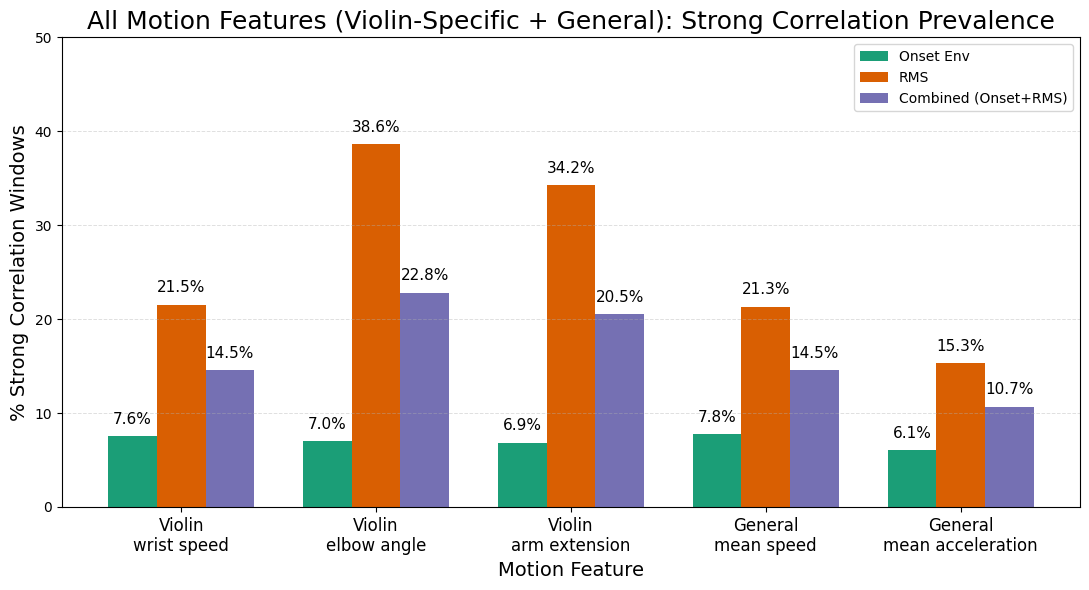

In [ ]:
# Grouped bar plots: single plot with all motion features (violin + general) each having three bars (onset, rms, combined)

if "global_results" not in globals():
    raise RuntimeError(
        "global_results not found. Run the previous cell first."
    )

# Helper to compute % strong windows for a single feature & audio feature


def compute_pct(group, motion_feat, audio_feat):
    strong = global_results["group_counts"][group][motion_feat][audio_feat]
    total = global_results["group_total_windows"][group][motion_feat][
        audio_feat
    ]
    return (strong / total * 100) if total else 0.0


# Helper to compute combined across audio features


def compute_combined_pct(group, motion_feat):
    strong_sum = sum(
        global_results["group_counts"][group][motion_feat][af]
        for af in audio_features_list
    )
    total_sum = sum(
        global_results["group_total_windows"][group][motion_feat][af]
        for af in audio_features_list
    )
    return (strong_sum / total_sum * 100) if total_sum else 0.0


# Build combined feature list: list of tuples (group, feature_name)
combined_feature_entries = [("violin", f) for f in violin_features_list] + [
    ("general", f) for f in general_features_list
]

n_feats = len(combined_feature_entries)
x = np.arange(n_feats)
bar_width = 0.25

onset_vals = [
    compute_pct(g, f, "onset_env") for g, f in combined_feature_entries
]
rms_vals = [compute_pct(g, f, "rms") for g, f in combined_feature_entries]
combined_vals = [
    compute_combined_pct(g, f) for g, f in combined_feature_entries
]

labels = [
    f"{g.capitalize()}\n{f.replace('_', ' ')}"
    for g, f in combined_feature_entries
]

plt.figure(figsize=(1.4 * n_feats + 4, 6))
plt.bar(
    x - bar_width,
    onset_vals,
    width=bar_width,
    color="#1b9e77",
    label="Onset Env",
)
plt.bar(x, rms_vals, width=bar_width, color="#d95f02", label="RMS")
plt.bar(
    x + bar_width,
    combined_vals,
    width=bar_width,
    color="#7570b3",
    label="Combined (Onset+RMS)",
)

plt.xticks(x, labels, fontsize=12)
plt.xlabel("Motion Feature", fontsize=14)
plt.ylabel("% Strong Correlation Windows", fontsize=14)
plt.ylim(0, 50)
plt.title(
    "All Motion Features (Violin-Specific + General): Strong Correlation Prevalence",
    fontsize=18,
)
plt.grid(axis="y", linestyle="--", alpha=0.4, linewidth=0.7)

# Annotate
for arr, offset in [
    (onset_vals, -bar_width),
    (rms_vals, 0),
    (combined_vals, bar_width),
]:
    for xi, v in zip(x, arr):
        if v <= 50:  # annotate only within plot range
            plt.text(
                xi + offset,
                min(v + 1, 49),
                f"{v:.1f}%",
                ha="center",
                va="bottom",
                fontsize=11,
            )
        else:
            # Indicate clipped value
            plt.text(
                xi + offset,
                49,
                ">50%",
                ha="center",
                va="top",
                fontsize=8,
                color="red",
            )

plt.legend()
plt.tight_layout()
plt.show()